# Train the ISIC 2024 Data
* Idea is to show how this works 
* This notebook will predicts on test using an average of all folds

In [77]:
import random
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.preprocessing import binarize
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import GroupKFold
import h5py
import io
from PIL import Image
import torch.nn as nn
from torch.utils.data import DataLoader
import timm
from tqdm import tqdm

# Setup

In [78]:
# Set up device and random seed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")

random_seed = 42
random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
#number of epochs to train for
num_epochs = 1


#train entire model vs. just the classifier
freeze_base_model = False  #didn't get good results

# if this is set to true - full model is only generated as part of scoring (quick_train_record_count used)
# this saves GPU quota - but saved model won't reflect what was scored...
full_train_only_when_scoring = False  #must be False to save full model!
quick_train_record_count = 500000   #need to get at least some positive cases even for test run

Using device: cuda
GPU: NVIDIA L40S
Number of GPUs: 4


# Load meta - and split folds
* Maintain consistency with tabular data in other notebooks

In [79]:
df_train = pd.read_csv("/data/bortiz4/isic-2024-challenge/train-metadata.csv")

num_folds = 5

gkf = GroupKFold(n_splits=num_folds)

df_train["fold"] = -1
for idx, (train_idx, val_idx) in enumerate(gkf.split(df_train, df_train["target"], groups=df_train["patient_id"])):
    df_train.loc[val_idx, "fold"] = idx

# Add summary
fold_summary = df_train.groupby("fold")["patient_id"].nunique().to_dict()
total_patients = df_train["patient_id"].nunique()

print(f"Fold Summary (patients per fold):")
for fold, count in fold_summary.items():
    if fold != -1:  # Exclude the initialization value
        print(f"Fold {fold}: {count} patients")
print(f"Total patients: {total_patients}")

/tmp/ipykernel_223189/3020479452.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv("/data/bortiz4/isic-2024-challenge/train-metadata.csv")


Fold Summary (patients per fold):
Fold 0: 206 patients
Fold 1: 209 patients
Fold 2: 208 patients
Fold 3: 209 patients
Fold 4: 210 patients
Total patients: 1042


# Load meta data / review

In [80]:
# Set the HDF5 file path
TRAIN_HDF5_FILE_PATH = '/data/bortiz4/isic-2024-challenge/train-image.hdf5'

# are we scoring?
scoring = False
#check length of test data to see if we are scoring....
test_length = len(pd.read_csv("/data/bortiz4/isic-2024-challenge/test-metadata.csv"))
if test_length > 3:
    scoring = True

if not scoring:
    if full_train_only_when_scoring:
        df_train = df_train.head(quick_train_record_count)
                
print("\nOriginal Dataset Summary:")
print(f"Total number of samples: {len(df_train)}")
print(f"Number of unique patients: {df_train['patient_id'].nunique()}")

original_positive_cases = df_train['target'].sum()
original_total_cases = len(df_train)
original_positive_ratio = original_positive_cases / original_total_cases

print(f"Number of positive cases: {original_positive_cases}")
print(f"Number of negative cases: {original_total_cases - original_positive_cases}")
print(f"Ratio of negative to positive cases: {(original_total_cases - original_positive_cases) / original_positive_cases:.2f}:1")


Original Dataset Summary:
Total number of samples: 401059
Number of unique patients: 1042
Number of positive cases: 393
Number of negative cases: 400666
Ratio of negative to positive cases: 1019.51:1


# Downsample Negatives / Keep All Positives
* Keeping just 1% of negatives!
* We only use a small subset of the data in each fold for training...

In [81]:
#keep all positives
df_target_1 = df_train[df_train['target'] == 1]

#just use 1% of negatives
df_target_0 = df_train[df_train['target'] == 0].sample(frac=0.01, random_state=42)

df_train_balanced = pd.concat([df_target_1, df_target_0]).reset_index(drop=True)

# Print balanced dataset summary
print("Balanced Dataset Summary:")
print(f"Total number of samples: {len(df_train)}")
print(f"Number of unique patients: {df_train['patient_id'].nunique()}")

#positive_cases = df_train_balanced['target'].sum()
total_cases = len(df_train_balanced)
positive_ratio = positive_cases / total_cases

print(f"Number of positive cases: {positive_cases}")
print(f"Number of negative cases: {total_cases - positive_cases}")
print(f"New ratio of negative to positive cases: {(total_cases - positive_cases) / positive_cases:.2f}:1")

# ImageNet Setup for Training

In [82]:
def setup_model(num_classes=2, freeze_base_model=freeze_base_model):
    model = timm.create_model('tf_efficientnetv2_b1', 
                            checkpoint_path='/data/bortiz4/tf_efficientnetv2_b1-be6e41b0.pth',
                            pretrained=False)

    if freeze_base_model:
        for param in model.parameters():
            param.requires_grad = False

    model.classifier = nn.Linear(model.classifier.in_features, out_features=num_classes)

    #Wrap model for multi-GPU training
    model = nn.DataParallel(model)
    return model.to(device)    

def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for name, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

# Data Loading / Image Augmentation

In [83]:
class ISICDataset(Dataset):
    def __init__(self, hdf5_file, isic_ids, targets=None, transform=None):
        self.hdf5_file = hdf5_file
        self.isic_ids = isic_ids
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.isic_ids)

    def __getitem__(self, idx):
        with h5py.File(self.hdf5_file, 'r') as f:
            img_bytes = f[self.isic_ids[idx]][()]
        
        img = Image.open(io.BytesIO(img_bytes))
        img = np.array(img)  # Convert PIL Image to numpy array
        
        if self.transform:
            transformed = self.transform(image=img)
            img = transformed['image']
        
        if self.targets is not None:
            target = self.targets[idx]
        else:
            target = torch.tensor(-1)  # Dummy target for test set
            
        return img, target
    
# Prepare augmentation
aug_transform = A.Compose([
    A.RandomRotate90(),
    A.Flip(),
    A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.1, p=0.5),
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

base_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

/tmp/ipykernel_223189/2734219048.py:32: DeprecationWarning: Flip is deprecated. Consider using HorizontalFlip, VerticalFlip, RandomRotate90 or D4.
  A.Flip(),


# Visualize image augmentation

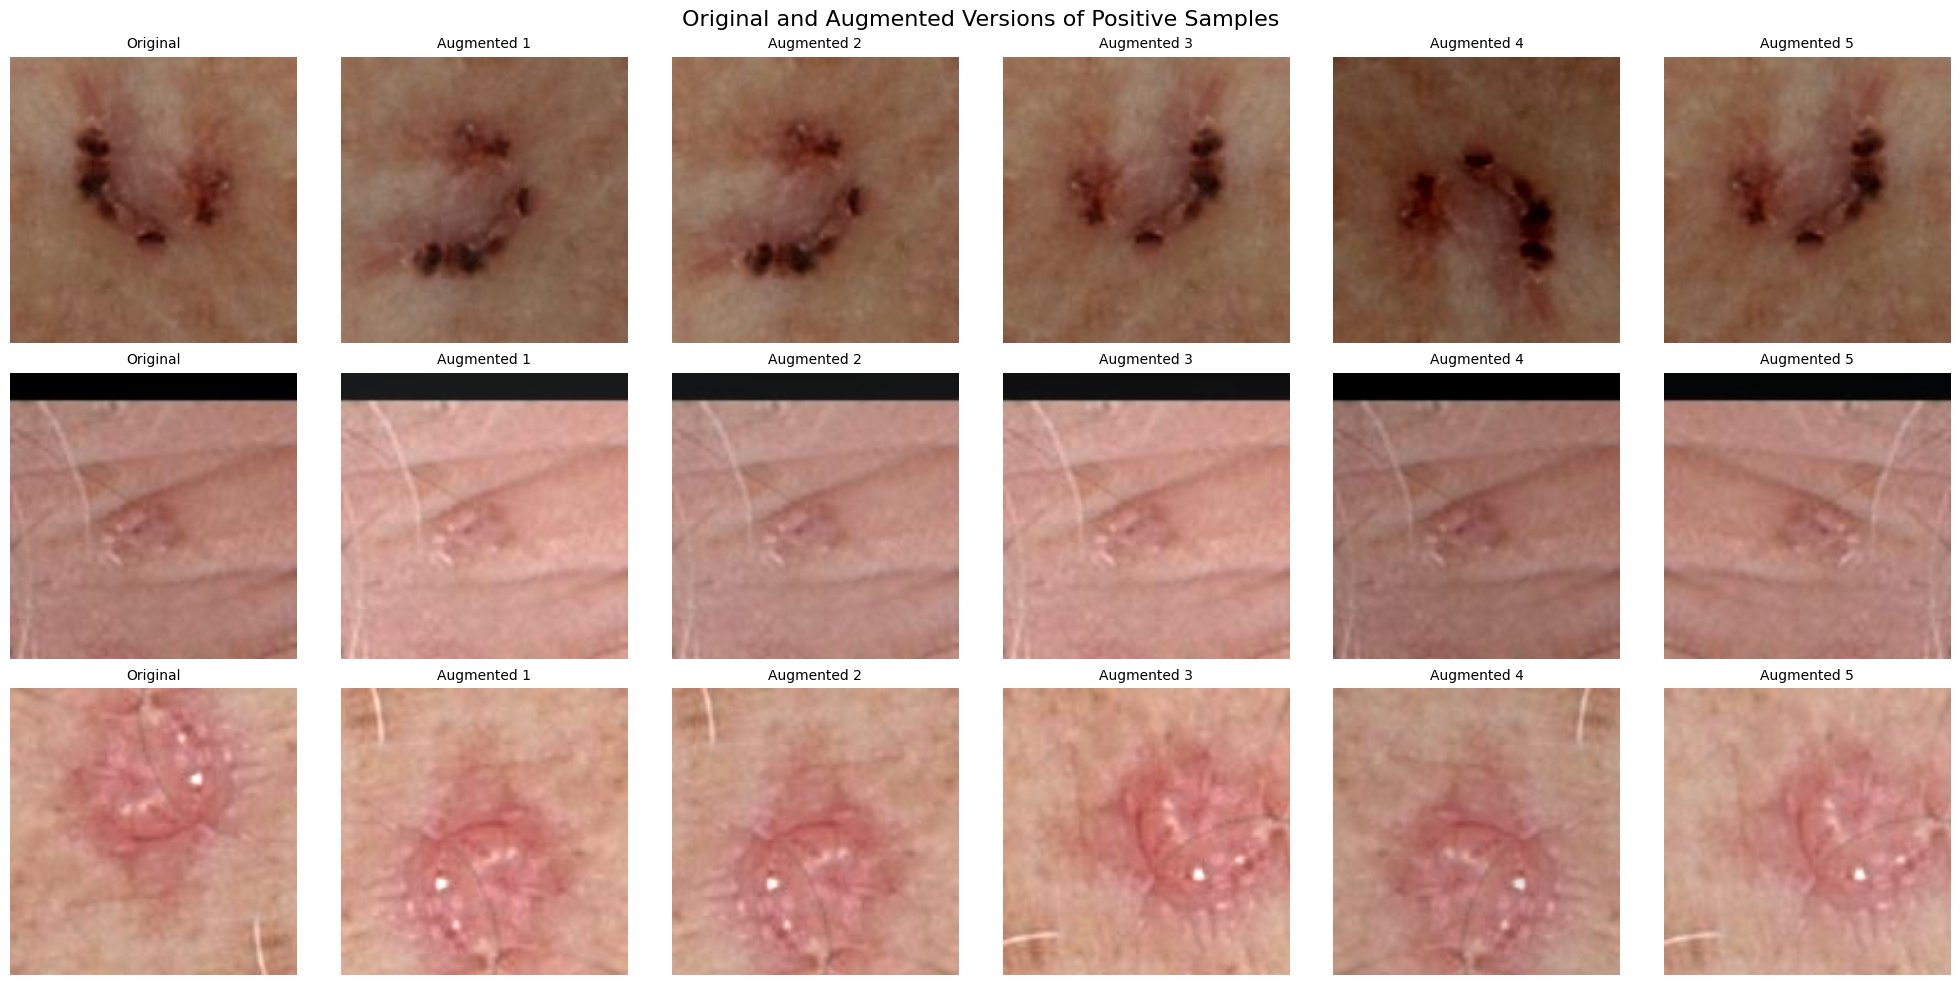

In [84]:
import matplotlib.pyplot as plt


def visualize_augmentations_positive(dataset, num_samples=3, num_augmentations=5, figsize=(20, 10)):
    # Find positive samples
    positive_samples = []
    for i in range(len(dataset)):
        _, label = dataset[i]
        if label == 1:  # Assuming 1 is the positive class
            positive_samples.append(i)

        if len(positive_samples) == num_samples:
            break
    
    if len(positive_samples) < num_samples:
        print(f"Warning: Only found {len(positive_samples)} positive samples.")
    
    fig, axes = plt.subplots(num_samples, num_augmentations + 1, figsize=figsize)
    fig.suptitle("Original and Augmented Versions of Positive Samples", fontsize=16)

    for sample_num, sample_idx in enumerate(positive_samples):
        # Get a single sample
        original_image, label = dataset[sample_idx]
        
        # If the image is already a tensor (due to ToTensorV2 in the transform), convert it back to numpy
        if isinstance(original_image, torch.Tensor):
            original_image = original_image.permute(1, 2, 0).numpy()
            
        # Reverse the normalization
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        original_image = (original_image * std + mean) * 255
        original_image = original_image.astype(np.uint8)

        # Display original image
        axes[sample_num, 0].imshow(original_image)
        axes[sample_num, 0].axis('off')
        axes[sample_num, 0].set_title("Original", fontsize=10)

        # Apply and display augmentations
        for aug_num in range(num_augmentations):
            augmented = dataset.transform(image=original_image)['image']
            # If the result is a tensor, convert it back to numpy
            if isinstance(augmented, torch.Tensor):
                augmented = augmented.permute(1, 2, 0).numpy()
            # Reverse the normalization
            augmented = (augmented * std + mean) * 255
            augmented = augmented.astype(np.uint8)
            
            axes[sample_num, aug_num + 1].imshow(augmented)
            axes[sample_num, aug_num + 1].axis('off')
            axes[sample_num, aug_num + 1].set_title(f"Augmented {aug_num + 1}", fontsize=10)

    plt.tight_layout()
    plt.show()
    
augtest_dataset = ISICDataset(
    hdf5_file=TRAIN_HDF5_FILE_PATH,
    isic_ids=df_train['isic_id'].values,
    targets=df_train['target'].values,
    transform=aug_transform,
)

visualize_augmentations_positive(augtest_dataset)

# Scoring code from https://www.kaggle.com/code/metric/isic-pauc-abovetpr

In [85]:
def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, min_tpr: float=0.80) -> float:

    del solution[row_id_column_name]
    del submission[row_id_column_name]

    # rescale the target. set 0s to 1s and 1s to 0s (since sklearn only has max_fpr)
    v_gt = abs(np.asarray(solution.values)-1)
    
    # flip the submissions to their compliments
    v_pred = -1.0*np.asarray(submission.values)

    max_fpr = abs(1-min_tpr)

    # using sklearn.metric functions: (1) roc_curve and (2) auc
    fpr, tpr, _ = roc_curve(v_gt, v_pred, sample_weight=None)
    if max_fpr is None or max_fpr == 1:
        return auc(fpr, tpr)
    if max_fpr <= 0 or max_fpr > 1:
        raise ValueError("Expected min_tpr in range [0, 1), got: %r" % min_tpr)
        
    # Add a single point at max_fpr by linear interpolation
    stop = np.searchsorted(fpr, max_fpr, "right")
    x_interp = [fpr[stop - 1], fpr[stop]]
    y_interp = [tpr[stop - 1], tpr[stop]]
    tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
    fpr = np.append(fpr[:stop], max_fpr)
    partial_auc = auc(fpr, tpr)

    return(partial_auc)

# Train / CV

In [86]:
import torch
import pandas as pd
from torch.cuda.amp import autocast, GradScaler
import numpy as np

def train_evaluate(model, train_loader, val_loader, criterion, optimizer, scheduler, fold, epoch, device):
    scaler = GradScaler()
    
    # Training phase
    model.train()
    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}, Fold {fold+1} Training"):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad(set_to_none=True)
        
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, targets)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    
    # Evaluation phase
    model.eval()
    val_targets, val_outputs = [], []
    with torch.no_grad(), autocast():
        for inputs, targets in tqdm(val_loader, desc=f"Epoch {epoch+1}, Fold {fold+1} Evaluating"):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            val_targets.append(targets.cpu())
            val_outputs.append(outputs.softmax(dim=1)[:, 1].cpu())
    
    scheduler.step()
    return torch.cat(val_targets).numpy(), torch.cat(val_outputs).numpy()


def cross_validation_train(df_train, num_folds, num_epochs, hdf5_file_path, aug_transform, base_transform, device):
    criterion = nn.CrossEntropyLoss()
    all_val_targets, all_val_outputs = [], []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        epoch_val_targets, epoch_val_outputs = [], []

        for fold in range(num_folds):
            print(f"\nFold {fold + 1}/{num_folds}")
            
            # Split data for current fold
            train_df = df_train[df_train['fold'] != fold]
            val_df = df_train[df_train['fold'] == fold]
            
            # Create datasets and data loaders
            train_dataset = ISICDataset(hdf5_file_path, train_df['isic_id'].values, train_df['target'].values, aug_transform)
            val_dataset = ISICDataset(hdf5_file_path, val_df['isic_id'].values, val_df['target'].values, base_transform)
            
            train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
            val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)
            
            # Initialize model, optimizer, and scheduler
            model = setup_model().to(device)
            optimizer = torch.optim.AdamW(model.parameters(), lr=0.002)
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
            
            print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, "
                  f"Train Pos Ratio: {train_df['target'].mean():.2%}, Val Pos Ratio: {val_df['target'].mean():.2%}")
            
            # Train and evaluate
            val_targets, val_outputs = train_evaluate(model, train_loader, val_loader, criterion, optimizer, scheduler, fold, epoch, device)
            epoch_val_targets.extend(val_targets)
            epoch_val_outputs.extend(val_outputs)
            
            torch.save(model.state_dict(), f'model_fold_{fold}_epoch_{epoch + 1}.pth')
            
            # Create DataFrames with row_id for scoring
            solution_df = pd.DataFrame({'target': val_targets, 'row_id': range(len(val_targets))})
            submission_df = pd.DataFrame({'prediction': val_outputs, 'row_id': range(len(val_outputs))})
            fold_score = score(solution_df, submission_df, 'row_id')
            print(f'Fold {fold + 1} pAUC Score: {fold_score:.4f}')
        
        all_val_targets.extend(epoch_val_targets)
        all_val_outputs.extend(epoch_val_outputs)
        
        # Create DataFrames with row_id for scoring
        solution_df = pd.DataFrame({'target': epoch_val_targets, 'row_id': range(len(epoch_val_targets))})
        submission_df = pd.DataFrame({'prediction': epoch_val_outputs, 'row_id': range(len(epoch_val_outputs))})
        cv_score = score(solution_df, submission_df, 'row_id')
        print(f'Epoch {epoch + 1}/{num_epochs} CV pAUC Score: {cv_score:.4f}')

    return np.array(all_val_targets), np.array(all_val_outputs)

# Set up CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# Perform cross-validation training
all_val_targets, all_val_outputs = cross_validation_train(df_train_balanced, num_folds, num_epochs, TRAIN_HDF5_FILE_PATH, aug_transform, base_transform, device)

/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Using device: cuda

Epoch 1/50

Fold 1/5
Train: 320845, Val: 80214, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 1, Fold 1 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.18it/s]

Fold 1 pAUC Score: 0.1109

Fold 2/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320847, Val: 80212, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 1, Fold 2 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.21it/s]

Fold 2 pAUC Score: 0.0776

Fold 3/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 1, Fold 3 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.25it/s]

Fold 3 pAUC Score: 0.1075

Fold 4/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.09%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 1, Fold 4 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.17it/s]

Fold 4 pAUC Score: 0.1010

Fold 5/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 1, Fold 5 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.26it/s]

Fold 5 pAUC Score: 0.0728
Epoch 1/50 CV pAUC Score: 0.0772

Epoch 2/50

Fold 1/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320845, Val: 80214, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 2, Fold 1 Evaluating: 100%|██████████| 314/314 [00:58<00:00,  5.34it/s]

Fold 1 pAUC Score: 0.0804

Fold 2/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320847, Val: 80212, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 2, Fold 2 Evaluating: 100%|██████████| 314/314 [01:01<00:00,  5.09it/s]

Fold 2 pAUC Score: 0.0731

Fold 3/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 2, Fold 3 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.18it/s]

Fold 3 pAUC Score: 0.1074

Fold 4/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.09%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 2, Fold 4 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.15it/s]

Fold 4 pAUC Score: 0.0820

Fold 5/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 2, Fold 5 Evaluating: 100%|██████████| 314/314 [01:01<00:00,  5.14it/s]

Fold 5 pAUC Score: 0.1008
Epoch 2/50 CV pAUC Score: 0.0796

Epoch 3/50

Fold 1/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320845, Val: 80214, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 3, Fold 1 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.21it/s]

Fold 1 pAUC Score: 0.0532

Fold 2/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320847, Val: 80212, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 3, Fold 2 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.27it/s]

Fold 2 pAUC Score: 0.0389

Fold 3/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 3, Fold 3 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.19it/s]

Fold 3 pAUC Score: 0.1112

Fold 4/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.09%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 3, Fold 4 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.24it/s]

Fold 4 pAUC Score: 0.0884

Fold 5/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 3, Fold 5 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.17it/s]

Fold 5 pAUC Score: 0.0222
Epoch 3/50 CV pAUC Score: 0.0505

Epoch 4/50

Fold 1/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320845, Val: 80214, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 4, Fold 1 Evaluating: 100%|██████████| 314/314 [01:01<00:00,  5.09it/s]

Fold 1 pAUC Score: 0.0932

Fold 2/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320847, Val: 80212, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 4, Fold 2 Evaluating: 100%|██████████| 314/314 [00:58<00:00,  5.33it/s]

Fold 2 pAUC Score: 0.0907

Fold 3/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 4, Fold 3 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.22it/s]

Fold 3 pAUC Score: 0.0541

Fold 4/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.09%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 4, Fold 4 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.27it/s]

Fold 4 pAUC Score: 0.0851

Fold 5/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 4, Fold 5 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.23it/s]

Fold 5 pAUC Score: 0.0791
Epoch 4/50 CV pAUC Score: 0.0559

Epoch 5/50

Fold 1/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320845, Val: 80214, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 5, Fold 1 Evaluating: 100%|██████████| 314/314 [01:02<00:00,  4.99it/s]

Fold 1 pAUC Score: 0.0897

Fold 2/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320847, Val: 80212, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 5, Fold 2 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.23it/s]

Fold 2 pAUC Score: 0.0342

Fold 3/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 5, Fold 3 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.24it/s]

Fold 3 pAUC Score: 0.1217

Fold 4/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.09%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 5, Fold 4 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.30it/s]

Fold 4 pAUC Score: 0.0014

Fold 5/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 5, Fold 5 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.19it/s]

Fold 5 pAUC Score: 0.1015
Epoch 5/50 CV pAUC Score: 0.0473

Epoch 6/50

Fold 1/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320845, Val: 80214, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 6, Fold 1 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.25it/s]

Fold 1 pAUC Score: 0.0509

Fold 2/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320847, Val: 80212, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 6, Fold 2 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.16it/s]

Fold 2 pAUC Score: 0.0454

Fold 3/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 6, Fold 3 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.28it/s]

Fold 3 pAUC Score: 0.1018

Fold 4/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.09%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 6, Fold 4 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.22it/s]

Fold 4 pAUC Score: 0.0961

Fold 5/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 6, Fold 5 Evaluating: 100%|██████████| 314/314 [00:52<00:00,  5.95it/s]

Fold 5 pAUC Score: 0.0647
Epoch 6/50 CV pAUC Score: 0.0452

Epoch 7/50

Fold 1/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320845, Val: 80214, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 7, Fold 1 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.31it/s]

Fold 1 pAUC Score: 0.0643

Fold 2/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320847, Val: 80212, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 7, Fold 2 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.23it/s]

Fold 2 pAUC Score: 0.0677

Fold 3/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 7, Fold 3 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.31it/s]

Fold 3 pAUC Score: 0.0863

Fold 4/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.09%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 7, Fold 4 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.27it/s]

Fold 4 pAUC Score: 0.0313

Fold 5/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 7, Fold 5 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.22it/s]

Fold 5 pAUC Score: 0.0322
Epoch 7/50 CV pAUC Score: 0.0454

Epoch 8/50

Fold 1/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320845, Val: 80214, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 8, Fold 1 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.22it/s]

Fold 1 pAUC Score: 0.0419

Fold 2/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320847, Val: 80212, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 8, Fold 2 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.21it/s]

Fold 2 pAUC Score: 0.0654

Fold 3/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 8, Fold 3 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.22it/s]

Fold 3 pAUC Score: 0.0717

Fold 4/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.09%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 8, Fold 4 Evaluating: 100%|██████████| 314/314 [01:02<00:00,  5.02it/s]

Fold 4 pAUC Score: 0.0848

Fold 5/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 8, Fold 5 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.22it/s]

Fold 5 pAUC Score: 0.0440
Epoch 8/50 CV pAUC Score: 0.0495

Epoch 9/50

Fold 1/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320845, Val: 80214, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 9, Fold 1 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.23it/s]

Fold 1 pAUC Score: 0.0833

Fold 2/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320847, Val: 80212, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 9, Fold 2 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.17it/s]

Fold 2 pAUC Score: 0.0660

Fold 3/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 9, Fold 3 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.25it/s]

Fold 3 pAUC Score: 0.1057

Fold 4/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.09%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 9, Fold 4 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.27it/s]

Fold 4 pAUC Score: 0.0818

Fold 5/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 9, Fold 5 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.27it/s]

Fold 5 pAUC Score: 0.0030
Epoch 9/50 CV pAUC Score: 0.0249

Epoch 10/50

Fold 1/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320845, Val: 80214, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 10, Fold 1 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.28it/s]

Fold 1 pAUC Score: 0.0007

Fold 2/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320847, Val: 80212, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 10, Fold 2 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.26it/s]

Fold 2 pAUC Score: 0.0927

Fold 3/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 10, Fold 3 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.19it/s]

Fold 3 pAUC Score: 0.0328

Fold 4/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.09%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 10, Fold 4 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.18it/s]

Fold 4 pAUC Score: 0.0897

Fold 5/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 10, Fold 5 Evaluating: 100%|██████████| 314/314 [00:53<00:00,  5.86it/s]

Fold 5 pAUC Score: 0.0891
Epoch 10/50 CV pAUC Score: 0.0305

Epoch 11/50

Fold 1/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320845, Val: 80214, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 11, Fold 1 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.30it/s]

Fold 1 pAUC Score: 0.0464

Fold 2/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320847, Val: 80212, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 11, Fold 2 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.23it/s]

Fold 2 pAUC Score: 0.0793

Fold 3/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 11, Fold 3 Evaluating: 100%|██████████| 314/314 [01:01<00:00,  5.12it/s]

Fold 3 pAUC Score: 0.0252

Fold 4/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.09%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 11, Fold 4 Evaluating: 100%|██████████| 314/314 [00:58<00:00,  5.32it/s]

Fold 4 pAUC Score: 0.0898

Fold 5/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 11, Fold 5 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.20it/s]

Fold 5 pAUC Score: 0.0518
Epoch 11/50 CV pAUC Score: 0.0465

Epoch 12/50

Fold 1/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320845, Val: 80214, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 12, Fold 1 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.18it/s]

Fold 1 pAUC Score: 0.0306

Fold 2/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320847, Val: 80212, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 12, Fold 2 Evaluating: 100%|██████████| 314/314 [00:55<00:00,  5.70it/s]

Fold 2 pAUC Score: 0.0795

Fold 3/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 12, Fold 3 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.15it/s]

Fold 3 pAUC Score: 0.1054

Fold 4/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.09%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 12, Fold 4 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.25it/s]

Fold 4 pAUC Score: 0.0874

Fold 5/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 12, Fold 5 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.30it/s]

Fold 5 pAUC Score: 0.0932
Epoch 12/50 CV pAUC Score: 0.0552

Epoch 13/50

Fold 1/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320845, Val: 80214, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 13, Fold 1 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.20it/s]

Fold 1 pAUC Score: 0.0682

Fold 2/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320847, Val: 80212, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 13, Fold 2 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.19it/s]

Fold 2 pAUC Score: 0.0846

Fold 3/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 13, Fold 3 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.27it/s]

Fold 3 pAUC Score: 0.0210

Fold 4/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.09%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 13, Fold 4 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.20it/s]

Fold 4 pAUC Score: 0.0705

Fold 5/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 13, Fold 5 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.22it/s]

Fold 5 pAUC Score: 0.0071
Epoch 13/50 CV pAUC Score: 0.0500

Epoch 14/50

Fold 1/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320845, Val: 80214, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 14, Fold 1 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.24it/s]

Fold 1 pAUC Score: 0.1155

Fold 2/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320847, Val: 80212, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 14, Fold 2 Evaluating: 100%|██████████| 314/314 [01:01<00:00,  5.10it/s]

Fold 2 pAUC Score: 0.0734

Fold 3/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 14, Fold 3 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.23it/s]

Fold 3 pAUC Score: 0.0892

Fold 4/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.09%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 14, Fold 4 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.25it/s]

Fold 4 pAUC Score: 0.0892

Fold 5/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 14, Fold 5 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.25it/s]

Fold 5 pAUC Score: 0.0391
Epoch 14/50 CV pAUC Score: 0.0706

Epoch 15/50

Fold 1/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320845, Val: 80214, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 15, Fold 1 Evaluating: 100%|██████████| 314/314 [01:02<00:00,  5.04it/s]

Fold 1 pAUC Score: 0.0862

Fold 2/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320847, Val: 80212, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 15, Fold 2 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.24it/s]

Fold 2 pAUC Score: 0.0427

Fold 3/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 15, Fold 3 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.24it/s]

Fold 3 pAUC Score: 0.0443

Fold 4/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.09%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 15, Fold 4 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.25it/s]

Fold 4 pAUC Score: 0.0938

Fold 5/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 15, Fold 5 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.19it/s]

Fold 5 pAUC Score: 0.1097
Epoch 15/50 CV pAUC Score: 0.0474

Epoch 16/50

Fold 1/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320845, Val: 80214, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 16, Fold 1 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.28it/s]

Fold 1 pAUC Score: 0.0332

Fold 2/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320847, Val: 80212, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 16, Fold 2 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.25it/s]

Fold 2 pAUC Score: 0.0965

Fold 3/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 16, Fold 3 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.31it/s]

Fold 3 pAUC Score: 0.0955

Fold 4/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.09%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 16, Fold 4 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.25it/s]

Fold 4 pAUC Score: 0.0653

Fold 5/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)


poch 18, Fold 4 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.19it/s]

Fold 4 pAUC Score: 0.0166

Fold 5/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 18, Fold 5 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.16it/s]

Fold 5 pAUC Score: 0.0661
Epoch 18/50 CV pAUC Score: 0.0434

Epoch 19/50

Fold 1/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320845, Val: 80214, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 19, Fold 1 Evaluating: 100%|██████████| 314/314 [01:01<00:00,  5.14it/s]

Fold 1 pAUC Score: 0.0834

Fold 2/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320847, Val: 80212, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 19, Fold 2 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.30it/s]

Fold 2 pAUC Score: 0.0725

Fold 3/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 19, Fold 3 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.23it/s]

Fold 3 pAUC Score: 0.0915

Fold 4/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.09%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 19, Fold 4 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.19it/s]

Fold 4 pAUC Score: 0.0024

Fold 5/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 19, Fold 5 Evaluating: 100%|██████████| 314/314 [01:01<00:00,  5.13it/s]

Fold 5 pAUC Score: 0.0123
Epoch 19/50 CV pAUC Score: 0.0320

Epoch 20/50

Fold 1/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320845, Val: 80214, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 20, Fold 1 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.28it/s]

Fold 1 pAUC Score: 0.0661

Fold 2/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320847, Val: 80212, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 20, Fold 2 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.26it/s]

Fold 2 pAUC Score: 0.0788

Fold 3/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 20, Fold 3 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.25it/s]

Fold 3 pAUC Score: 0.1118

Fold 4/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.09%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 20, Fold 4 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.15it/s]

Fold 4 pAUC Score: 0.0629

Fold 5/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 20, Fold 5 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.31it/s]

Fold 5 pAUC Score: 0.0925
Epoch 20/50 CV pAUC Score: 0.0785

Epoch 21/50

Fold 1/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320845, Val: 80214, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 21, Fold 1 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.18it/s]

Fold 1 pAUC Score: 0.0202

Fold 2/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320847, Val: 80212, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 21, Fold 2 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.24it/s]

Fold 2 pAUC Score: 0.0443

Fold 3/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 21, Fold 3 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.29it/s]

Fold 3 pAUC Score: 0.1109

Fold 4/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.09%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 21, Fold 4 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.28it/s]

Fold 4 pAUC Score: 0.0358

Fold 5/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 21, Fold 5 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.21it/s]

Fold 5 pAUC Score: 0.0401
Epoch 21/50 CV pAUC Score: 0.0513

Epoch 22/50

Fold 1/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320845, Val: 80214, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 22, Fold 1 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.15it/s]

Fold 1 pAUC Score: 0.0032

Fold 2/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320847, Val: 80212, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 22, Fold 2 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.21it/s]

Fold 2 pAUC Score: 0.0722

Fold 3/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 22, Fold 3 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.25it/s]

Fold 3 pAUC Score: 0.0039

Fold 4/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.09%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 22, Fold 4 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.18it/s]

Fold 4 pAUC Score: 0.0916

Fold 5/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 22, Fold 5 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.18it/s]

Fold 5 pAUC Score: 0.0286
Epoch 22/50 CV pAUC Score: 0.0210

Epoch 23/50

Fold 1/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320845, Val: 80214, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 23, Fold 1 Evaluating: 100%|██████████| 314/314 [01:01<00:00,  5.12it/s]

Fold 1 pAUC Score: 0.0815

Fold 2/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320847, Val: 80212, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 23, Fold 2 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.29it/s]

Fold 2 pAUC Score: 0.0733

Fold 3/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 23, Fold 3 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.17it/s]

Fold 3 pAUC Score: 0.0888

Fold 4/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.09%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 23, Fold 4 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.26it/s]

Fold 4 pAUC Score: 0.0756

Fold 5/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 23, Fold 5 Evaluating: 100%|██████████| 314/314 [00:57<00:00,  5.43it/s]

Fold 5 pAUC Score: 0.0988
Epoch 23/50 CV pAUC Score: 0.0582

Epoch 24/50

Fold 1/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320845, Val: 80214, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 24, Fold 1 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.25it/s]

Fold 1 pAUC Score: 0.0862

Fold 2/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320847, Val: 80212, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 24, Fold 2 Evaluating: 100%|██████████| 314/314 [00:58<00:00,  5.33it/s]

Fold 2 pAUC Score: 0.0599

Fold 3/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 24, Fold 3 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.21it/s]

Fold 3 pAUC Score: 0.1070

Fold 4/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.09%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 24, Fold 4 Evaluating: 100%|██████████| 314/314 [00:53<00:00,  5.90it/s]

Fold 4 pAUC Score: 0.0887

Fold 5/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 24, Fold 5 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.29it/s]

Fold 5 pAUC Score: 0.1089
Epoch 24/50 CV pAUC Score: 0.0717

Epoch 25/50

Fold 1/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320845, Val: 80214, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 25, Fold 1 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.17it/s]

Fold 1 pAUC Score: 0.0270

Fold 2/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320847, Val: 80212, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 25, Fold 2 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.17it/s]

Fold 2 pAUC Score: 0.0904

Fold 3/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 25, Fold 3 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.21it/s]

Fold 3 pAUC Score: 0.0663

Fold 4/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.09%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 25, Fold 4 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.29it/s]

Fold 4 pAUC Score: 0.0884

Fold 5/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 25, Fold 5 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.17it/s]

Fold 5 pAUC Score: 0.0467
Epoch 25/50 CV pAUC Score: 0.0524

Epoch 26/50

Fold 1/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320845, Val: 80214, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 26, Fold 1 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.17it/s]

Fold 1 pAUC Score: 0.1068

Fold 2/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320847, Val: 80212, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 26, Fold 2 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.25it/s]

Fold 2 pAUC Score: 0.0783

Fold 3/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 26, Fold 3 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.18it/s]

Fold 3 pAUC Score: 0.0070

Fold 4/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.09%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 26, Fold 4 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.24it/s]

Fold 4 pAUC Score: 0.0790

Fold 5/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 26, Fold 5 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.20it/s]

Fold 5 pAUC Score: 0.0819
Epoch 26/50 CV pAUC Score: 0.0388

Epoch 27/50

Fold 1/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320845, Val: 80214, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 27, Fold 1 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.24it/s]

Fold 1 pAUC Score: 0.0696

Fold 2/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320847, Val: 80212, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 27, Fold 2 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.28it/s]

Fold 2 pAUC Score: 0.0726

Fold 3/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 27, Fold 3 Evaluating: 100%|██████████| 314/314 [01:01<00:00,  5.11it/s]

Fold 3 pAUC Score: 0.1079

Fold 4/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.09%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 27, Fold 4 Evaluating: 100%|██████████| 314/314 [01:02<00:00,  5.01it/s]

Fold 4 pAUC Score: 0.0845

Fold 5/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 27, Fold 5 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.18it/s]

Fold 5 pAUC Score: 0.0426
Epoch 27/50 CV pAUC Score: 0.0567

Epoch 28/50

Fold 1/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320845, Val: 80214, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 28, Fold 1 Evaluating: 100%|██████████| 314/314 [01:01<00:00,  5.12it/s]

Fold 1 pAUC Score: 0.0701

Fold 2/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320847, Val: 80212, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 28, Fold 2 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.18it/s]

Fold 2 pAUC Score: 0.0831

Fold 3/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 28, Fold 3 Evaluating: 100%|██████████| 314/314 [01:01<00:00,  5.09it/s]

Fold 3 pAUC Score: 0.0021

Fold 4/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.09%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 28, Fold 4 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.21it/s]

Fold 4 pAUC Score: 0.0915

Fold 5/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 28, Fold 5 Evaluating: 100%|██████████| 314/314 [01:02<00:00,  5.02it/s]

Fold 5 pAUC Score: 0.0361
Epoch 28/50 CV pAUC Score: 0.0349

Epoch 29/50

Fold 1/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320845, Val: 80214, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 29, Fold 1 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.22it/s]

Fold 1 pAUC Score: 0.1054

Fold 2/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320847, Val: 80212, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 29, Fold 2 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.19it/s]

Fold 2 pAUC Score: 0.0300

Fold 3/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 29, Fold 3 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.22it/s]

Fold 3 pAUC Score: 0.0729

Fold 4/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.09%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 29, Fold 4 Evaluating: 100%|██████████| 314/314 [01:01<00:00,  5.14it/s]

Fold 4 pAUC Score: 0.0597

Fold 5/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 29, Fold 5 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.27it/s]

Fold 5 pAUC Score: 0.0755
Epoch 29/50 CV pAUC Score: 0.0557

Epoch 30/50

Fold 1/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320845, Val: 80214, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 30, Fold 1 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.15it/s]

Fold 1 pAUC Score: 0.0495

Fold 2/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320847, Val: 80212, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 30, Fold 2 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.27it/s]

Fold 2 pAUC Score: 0.0851

Fold 3/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 30, Fold 3 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.26it/s]

Fold 3 pAUC Score: 0.0886

Fold 4/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.09%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 30, Fold 4 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.27it/s]

Fold 4 pAUC Score: 0.0912

Fold 5/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 30, Fold 5 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.24it/s]

Fold 5 pAUC Score: 0.0711
Epoch 30/50 CV pAUC Score: 0.0556

Epoch 31/50

Fold 1/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320845, Val: 80214, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 31, Fold 1 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.26it/s]

Fold 1 pAUC Score: 0.0840

Fold 2/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320847, Val: 80212, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 31, Fold 2 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.26it/s]

Fold 2 pAUC Score: 0.0419

Fold 3/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 31, Fold 3 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.27it/s]

Fold 3 pAUC Score: 0.0456

Fold 4/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.09%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 31, Fold 4 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.19it/s]

Fold 4 pAUC Score: 0.1051

Fold 5/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 31, Fold 5 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.28it/s]

Fold 5 pAUC Score: 0.0689
Epoch 31/50 CV pAUC Score: 0.0406

Epoch 32/50

Fold 1/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320845, Val: 80214, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 32, Fold 1 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.26it/s]

Fold 1 pAUC Score: 0.0290

Fold 2/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320847, Val: 80212, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 32, Fold 2 Evaluating: 100%|██████████| 314/314 [01:01<00:00,  5.10it/s]

Fold 2 pAUC Score: 0.0587

Fold 3/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 32, Fold 3 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.32it/s]

Fold 3 pAUC Score: 0.0819

Fold 4/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.09%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 32, Fold 4 Evaluating: 100%|██████████| 314/314 [00:54<00:00,  5.77it/s]

Fold 4 pAUC Score: 0.0891

Fold 5/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 32, Fold 5 Evaluating: 100%|██████████| 314/314 [01:03<00:00,  4.96it/s]

Fold 5 pAUC Score: 0.0921
Epoch 32/50 CV pAUC Score: 0.0501

Epoch 33/50

Fold 1/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320845, Val: 80214, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 33, Fold 1 Evaluating: 100%|██████████| 314/314 [01:09<00:00,  4.54it/s]

Fold 1 pAUC Score: 0.0721

Fold 2/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320847, Val: 80212, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 33, Fold 2 Evaluating: 100%|██████████| 314/314 [00:54<00:00,  5.81it/s]

Fold 2 pAUC Score: 0.0425

Fold 3/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 33, Fold 3 Evaluating: 100%|██████████| 314/314 [01:05<00:00,  4.80it/s]

Fold 3 pAUC Score: 0.1133

Fold 4/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.09%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 33, Fold 4 Evaluating: 100%|██████████| 314/314 [00:57<00:00,  5.43it/s]

Fold 4 pAUC Score: 0.0780

Fold 5/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 33, Fold 5 Evaluating: 100%|██████████| 314/314 [01:05<00:00,  4.80it/s]

Fold 5 pAUC Score: 0.0679
Epoch 33/50 CV pAUC Score: 0.0669

Epoch 34/50

Fold 1/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320845, Val: 80214, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 34, Fold 1 Evaluating: 100%|██████████| 314/314 [01:06<00:00,  4.75it/s]

Fold 1 pAUC Score: 0.0443

Fold 2/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320847, Val: 80212, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 34, Fold 2 Evaluating: 100%|██████████| 314/314 [01:07<00:00,  4.64it/s]

Fold 2 pAUC Score: 0.0478

Fold 3/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 34, Fold 3 Evaluating: 100%|██████████| 314/314 [01:06<00:00,  4.74it/s]

Fold 3 pAUC Score: 0.0996

Fold 4/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.09%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 34, Fold 4 Evaluating: 100%|██████████| 314/314 [01:05<00:00,  4.77it/s]

Fold 4 pAUC Score: 0.0777

Fold 5/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 34, Fold 5 Evaluating: 100%|██████████| 314/314 [01:05<00:00,  4.76it/s]

Fold 5 pAUC Score: 0.0559
Epoch 34/50 CV pAUC Score: 0.0503

Epoch 35/50

Fold 1/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320845, Val: 80214, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 35, Fold 1 Evaluating: 100%|██████████| 314/314 [01:04<00:00,  4.85it/s]

Fold 1 pAUC Score: 0.0560

Fold 2/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320847, Val: 80212, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 35, Fold 2 Evaluating: 100%|██████████| 314/314 [01:06<00:00,  4.69it/s]

Fold 2 pAUC Score: 0.0890

Fold 3/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 35, Fold 3 Evaluating: 100%|██████████| 314/314 [01:06<00:00,  4.71it/s]

Fold 3 pAUC Score: 0.1176

Fold 4/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.09%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 35, Fold 4 Evaluating: 100%|██████████| 314/314 [01:06<00:00,  4.72it/s]

Fold 4 pAUC Score: 0.0945

Fold 5/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 35, Fold 5 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.23it/s]

Fold 5 pAUC Score: 0.1038
Epoch 35/50 CV pAUC Score: 0.0765

Epoch 36/50

Fold 1/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320845, Val: 80214, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 36, Fold 1 Evaluating: 100%|██████████| 314/314 [01:01<00:00,  5.12it/s]

Fold 1 pAUC Score: 0.0957

Fold 2/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320847, Val: 80212, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 36, Fold 2 Evaluating: 100%|██████████| 314/314 [01:01<00:00,  5.14it/s]

Fold 2 pAUC Score: 0.0522

Fold 3/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 36, Fold 3 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.23it/s]

Fold 3 pAUC Score: 0.0314

Fold 4/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.09%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)


/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 37, Fold 2 Evaluating: 100%|██████████| 314/314 [01:02<00:00,  5.03it/s]

Fold 2 pAUC Score: 0.0684

Fold 3/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 37, Fold 3 Evaluating: 100%|██████████| 314/314 [01:00<00:00,  5.22it/s]

Fold 3 pAUC Score: 0.0963

Fold 4/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.09%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 37, Fold 4 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.25it/s]

Fold 4 pAUC Score: 0.1009

Fold 5/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 37, Fold 5 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.27it/s]

Fold 5 pAUC Score: 0.1038
Epoch 37/50 CV pAUC Score: 0.0655

Epoch 38/50

Fold 1/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320845, Val: 80214, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 38, Fold 1 Evaluating: 100%|██████████| 314/314 [01:01<00:00,  5.15it/s]

Fold 1 pAUC Score: 0.0043

Fold 2/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320847, Val: 80212, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 38, Fold 2 Evaluating: 100%|██████████| 314/314 [01:02<00:00,  5.05it/s]

Fold 2 pAUC Score: 0.0553

Fold 3/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 38, Fold 3 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.27it/s]

Fold 3 pAUC Score: 0.0383

Fold 4/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.09%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 38, Fold 4 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.27it/s]

Fold 4 pAUC Score: 0.0942

Fold 5/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 38, Fold 5 Evaluating: 100%|██████████| 314/314 [00:59<00:00,  5.29it/s]

Fold 5 pAUC Score: 0.0899
Epoch 38/50 CV pAUC Score: 0.0352

Epoch 39/50

Fold 1/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320845, Val: 80214, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 39, Fold 1 Evaluating: 100%|██████████| 314/314 [01:06<00:00,  4.72it/s]

Fold 1 pAUC Score: 0.0647

Fold 2/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320847, Val: 80212, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 39, Fold 2 Evaluating: 100%|██████████| 314/314 [01:06<00:00,  4.71it/s]

Fold 2 pAUC Score: 0.0625

Fold 3/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 39, Fold 3 Evaluating: 100%|██████████| 314/314 [01:07<00:00,  4.67it/s]

Fold 3 pAUC Score: 0.0222

Fold 4/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.09%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 39, Fold 4 Evaluating: 100%|██████████| 314/314 [01:07<00:00,  4.67it/s]

Fold 4 pAUC Score: 0.0637

Fold 5/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 39, Fold 5 Evaluating: 100%|██████████| 314/314 [01:06<00:00,  4.74it/s]

Fold 5 pAUC Score: 0.1114
Epoch 39/50 CV pAUC Score: 0.0512

Epoch 40/50

Fold 1/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320845, Val: 80214, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 40, Fold 1 Evaluating: 100%|██████████| 314/314 [01:06<00:00,  4.75it/s]

Fold 1 pAUC Score: 0.0064

Fold 2/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320847, Val: 80212, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 40, Fold 2 Evaluating: 100%|██████████| 314/314 [01:05<00:00,  4.79it/s]

Fold 2 pAUC Score: 0.0105

Fold 3/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 40, Fold 3 Evaluating: 100%|██████████| 314/314 [01:08<00:00,  4.56it/s]

Fold 3 pAUC Score: 0.1081

Fold 4/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.09%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 40, Fold 4 Evaluating: 100%|██████████| 314/314 [01:06<00:00,  4.74it/s]

Fold 4 pAUC Score: 0.0970

Fold 5/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 40, Fold 5 Evaluating: 100%|██████████| 314/314 [01:05<00:00,  4.77it/s]

Fold 5 pAUC Score: 0.0989
Epoch 40/50 CV pAUC Score: 0.0612

Epoch 41/50

Fold 1/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320845, Val: 80214, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 41, Fold 1 Evaluating: 100%|██████████| 314/314 [01:04<00:00,  4.86it/s]

Fold 1 pAUC Score: 0.0472

Fold 2/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320847, Val: 80212, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 41, Fold 2 Evaluating: 100%|██████████| 314/314 [01:07<00:00,  4.66it/s]

Fold 2 pAUC Score: 0.0875

Fold 3/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 41, Fold 3 Evaluating: 100%|██████████| 314/314 [01:05<00:00,  4.77it/s]

Fold 3 pAUC Score: 0.0989

Fold 4/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.09%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 41, Fold 4 Evaluating: 100%|██████████| 314/314 [01:04<00:00,  4.90it/s]

Fold 4 pAUC Score: 0.0936

Fold 5/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 41, Fold 5 Evaluating: 100%|██████████| 314/314 [01:06<00:00,  4.72it/s]

Fold 5 pAUC Score: 0.0932
Epoch 41/50 CV pAUC Score: 0.0641

Epoch 42/50

Fold 1/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320845, Val: 80214, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 42, Fold 1 Evaluating: 100%|██████████| 314/314 [01:06<00:00,  4.73it/s]

Fold 1 pAUC Score: 0.0364

Fold 2/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320847, Val: 80212, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 42, Fold 2 Evaluating: 100%|██████████| 314/314 [01:06<00:00,  4.69it/s]

Fold 2 pAUC Score: 0.0632

Fold 3/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 42, Fold 3 Evaluating: 100%|██████████| 314/314 [01:04<00:00,  4.84it/s]

Fold 3 pAUC Score: 0.0677

Fold 4/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.09%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 42, Fold 4 Evaluating: 100%|██████████| 314/314 [01:06<00:00,  4.75it/s]

Fold 4 pAUC Score: 0.1064

Fold 5/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 42, Fold 5 Evaluating: 100%|██████████| 314/314 [01:05<00:00,  4.82it/s]

Fold 5 pAUC Score: 0.0183
Epoch 42/50 CV pAUC Score: 0.0488

Epoch 43/50

Fold 1/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320845, Val: 80214, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 43, Fold 1 Evaluating: 100%|██████████| 314/314 [01:05<00:00,  4.79it/s]

Fold 1 pAUC Score: 0.1046

Fold 2/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320847, Val: 80212, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 43, Fold 2 Evaluating: 100%|██████████| 314/314 [01:04<00:00,  4.84it/s]

Fold 2 pAUC Score: 0.0604

Fold 3/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 43, Fold 3 Evaluating: 100%|██████████| 314/314 [01:06<00:00,  4.75it/s]

Fold 3 pAUC Score: 0.1209

Fold 4/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.09%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 43, Fold 4 Evaluating: 100%|██████████| 314/314 [01:07<00:00,  4.65it/s]

Fold 4 pAUC Score: 0.0773

Fold 5/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 43, Fold 5 Evaluating: 100%|██████████| 314/314 [01:06<00:00,  4.75it/s]

Fold 5 pAUC Score: 0.0926
Epoch 43/50 CV pAUC Score: 0.0691

Epoch 44/50

Fold 1/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320845, Val: 80214, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 44, Fold 1 Evaluating: 100%|██████████| 314/314 [01:04<00:00,  4.88it/s]

Fold 1 pAUC Score: 0.0763

Fold 2/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320847, Val: 80212, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 44, Fold 2 Evaluating: 100%|██████████| 314/314 [01:08<00:00,  4.57it/s]

Fold 2 pAUC Score: 0.0662

Fold 3/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 44, Fold 3 Evaluating: 100%|██████████| 314/314 [01:06<00:00,  4.73it/s]

Fold 3 pAUC Score: 0.0065

Fold 4/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.09%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 44, Fold 4 Evaluating: 100%|██████████| 314/314 [01:09<00:00,  4.55it/s]

Fold 4 pAUC Score: 0.0480

Fold 5/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 44, Fold 5 Evaluating: 100%|██████████| 314/314 [01:04<00:00,  4.83it/s]

Fold 5 pAUC Score: 0.0554
Epoch 44/50 CV pAUC Score: 0.0536

Epoch 45/50

Fold 1/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320845, Val: 80214, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 45, Fold 1 Evaluating: 100%|██████████| 314/314 [01:07<00:00,  4.66it/s]

Fold 1 pAUC Score: 0.0654

Fold 2/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320847, Val: 80212, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 45, Fold 2 Evaluating: 100%|██████████| 314/314 [01:06<00:00,  4.73it/s]

Fold 2 pAUC Score: 0.0535

Fold 3/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 45, Fold 3 Evaluating: 100%|██████████| 314/314 [01:06<00:00,  4.69it/s]

Fold 3 pAUC Score: 0.1046

Fold 4/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.09%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 45, Fold 4 Evaluating: 100%|██████████| 314/314 [01:06<00:00,  4.75it/s]

Fold 4 pAUC Score: 0.0553

Fold 5/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 45, Fold 5 Evaluating: 100%|██████████| 314/314 [01:05<00:00,  4.79it/s]

Fold 5 pAUC Score: 0.0964
Epoch 45/50 CV pAUC Score: 0.0457

Epoch 46/50

Fold 1/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320845, Val: 80214, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 46, Fold 1 Evaluating: 100%|██████████| 314/314 [01:05<00:00,  4.78it/s]

Fold 1 pAUC Score: 0.0291

Fold 2/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320847, Val: 80212, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 46, Fold 2 Evaluating: 100%|██████████| 314/314 [01:05<00:00,  4.82it/s]

Fold 2 pAUC Score: 0.0916

Fold 3/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 46, Fold 3 Evaluating: 100%|██████████| 314/314 [01:06<00:00,  4.71it/s]

Fold 3 pAUC Score: 0.1189

Fold 4/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.09%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 46, Fold 4 Evaluating: 100%|██████████| 314/314 [01:05<00:00,  4.78it/s]

Fold 4 pAUC Score: 0.0950

Fold 5/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 46, Fold 5 Evaluating: 100%|██████████| 314/314 [01:08<00:00,  4.62it/s]

Fold 5 pAUC Score: 0.0334
Epoch 46/50 CV pAUC Score: 0.0751

Epoch 47/50

Fold 1/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320845, Val: 80214, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 47, Fold 1 Evaluating: 100%|██████████| 314/314 [01:07<00:00,  4.68it/s]

Fold 1 pAUC Score: 0.0778

Fold 2/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320847, Val: 80212, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 47, Fold 2 Evaluating: 100%|██████████| 314/314 [01:08<00:00,  4.56it/s]

Fold 2 pAUC Score: 0.0664

Fold 3/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 47, Fold 3 Evaluating: 100%|██████████| 314/314 [01:08<00:00,  4.56it/s]

Fold 3 pAUC Score: 0.1069

Fold 4/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.09%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 47, Fold 4 Evaluating: 100%|██████████| 314/314 [01:09<00:00,  4.54it/s]

Fold 4 pAUC Score: 0.0588

Fold 5/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 47, Fold 5 Evaluating: 100%|██████████| 314/314 [01:05<00:00,  4.80it/s]

Fold 5 pAUC Score: 0.0894
Epoch 47/50 CV pAUC Score: 0.0512

Epoch 48/50

Fold 1/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320845, Val: 80214, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 48, Fold 1 Evaluating: 100%|██████████| 314/314 [01:09<00:00,  4.54it/s]

Fold 1 pAUC Score: 0.0503

Fold 2/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320847, Val: 80212, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 48, Fold 2 Evaluating: 100%|██████████| 314/314 [01:05<00:00,  4.79it/s]

Fold 2 pAUC Score: 0.0191

Fold 3/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 48, Fold 3 Evaluating: 100%|██████████| 314/314 [01:05<00:00,  4.78it/s]

Fold 3 pAUC Score: 0.1180

Fold 4/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.09%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 48, Fold 4 Evaluating: 100%|██████████| 314/314 [01:05<00:00,  4.80it/s]

Fold 4 pAUC Score: 0.0729

Fold 5/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 48, Fold 5 Evaluating: 100%|██████████| 314/314 [01:05<00:00,  4.77it/s]

Fold 5 pAUC Score: 0.0857
Epoch 48/50 CV pAUC Score: 0.0471

Epoch 49/50

Fold 1/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320845, Val: 80214, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 49, Fold 1 Evaluating: 100%|██████████| 314/314 [01:07<00:00,  4.68it/s]

Fold 1 pAUC Score: 0.1140

Fold 2/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320847, Val: 80212, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 49, Fold 2 Evaluating: 100%|██████████| 314/314 [01:07<00:00,  4.68it/s]

Fold 2 pAUC Score: 0.0528

Fold 3/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 49, Fold 3 Evaluating: 100%|██████████| 314/314 [01:06<00:00,  4.73it/s]

Fold 3 pAUC Score: 0.0803

Fold 4/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.09%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 49, Fold 4 Evaluating: 100%|██████████| 314/314 [01:05<00:00,  4.83it/s]

Fold 4 pAUC Score: 0.0680

Fold 5/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 49, Fold 5 Evaluating: 100%|██████████| 314/314 [01:04<00:00,  4.84it/s]

Fold 5 pAUC Score: 0.0210
Epoch 49/50 CV pAUC Score: 0.0626

Epoch 50/50

Fold 1/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320845, Val: 80214, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 50, Fold 1 Evaluating: 100%|██████████| 314/314 [01:04<00:00,  4.83it/s]

Fold 1 pAUC Score: 0.0321

Fold 2/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320847, Val: 80212, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 50, Fold 2 Evaluating: 100%|██████████| 314/314 [01:06<00:00,  4.71it/s]

Fold 2 pAUC Score: 0.0574

Fold 3/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 50, Fold 3 Evaluating: 100%|██████████| 314/314 [01:06<00:00,  4.69it/s]

Fold 3 pAUC Score: 0.0599

Fold 4/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.09%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 50, Fold 4 Evaluating: 100%|██████████| 314/314 [01:07<00:00,  4.62it/s]

Fold 4 pAUC Score: 0.0881

Fold 5/5


/tmp/ipykernel_223189/346826373.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 320848, Val: 80211, Train Pos Ratio: 0.10%, Val Pos Ratio: 0.10%


/tmp/ipykernel_223189/346826373.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_223189/346826373.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 50, Fold 5 Evaluating: 100%|██████████| 314/314 [01:05<00:00,  4.81it/s]

Fold 5 pAUC Score: 0.1067
Epoch 50/50 CV pAUC Score: 0.0500


In [87]:
# Final overall evaluation
print("\nFinal Overall Evaluation:")

# Calculate the official pAUC score
solution_df = pd.DataFrame({'target': all_val_targets, 'row_id': range(len(all_val_targets))})
submission_df = pd.DataFrame({'prediction': all_val_outputs, 'row_id': range(len(all_val_outputs))})
official_score = score(solution_df, submission_df, 'row_id')
print(f'Overall pAUC Score: {official_score:.4f}')

# Generate and print classification report
binary_predictions = binarize(np.array(all_val_outputs).reshape(-1, 1), threshold=0.5).reshape(-1)
report = classification_report(all_val_targets, binary_predictions, target_names=['Class 0', 'Class 1'])
print("\nOverall Classification Report:")
print(report)

# Print specific metrics for Class 1
report_dict = classification_report(all_val_targets, binary_predictions, target_names=['Class 0', 'Class 1'], output_dict=True)
print(f"\nClass 1 Metrics:")
print(f"Precision: {report_dict['Class 1']['precision']:.4f}")
print(f"Recall: {report_dict['Class 1']['recall']:.4f}")
print(f"F1-score: {report_dict['Class 1']['f1-score']:.4f}")


Final Overall Evaluation:
Overall pAUC Score: 0.0491

Overall Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00  20033300
     Class 1       0.00      0.00      0.00     19650

    accuracy                           1.00  20052950
   macro avg       0.50      0.50      0.50  20052950
weighted avg       1.00      1.00      1.00  20052950


Class 1 Metrics:
Precision: 0.0031
Recall: 0.0003
F1-score: 0.0005


# Inference Code


In [88]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from tqdm import tqdm
import h5py
import timm
from PIL import Image
import io
import albumentations as A
from albumentations.pytorch import ToTensorV2

epoch_for_preds = num_epochs
model_path = "/tmp/pycharm_project_570/"
class ISICDataset(Dataset):
    def __init__(self, hdf5_file, isic_ids, targets=None, transform=None):
        self.hdf5_file = h5py.File(hdf5_file, 'r')  # Keep file open
        self.isic_ids = isic_ids
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.isic_ids)

    def __getitem__(self, idx):
        img_bytes = self.hdf5_file[self.isic_ids[idx]][()]
        img = Image.open(io.BytesIO(img_bytes))
        img = np.array(img)

        if self.transform:
            transformed = self.transform(image=img)
            img = transformed['image']

        target = self.targets[idx] if self.targets is not None else torch.tensor(-1)
        return img, target

    def __del__(self):
        self.hdf5_file.close()  # Ensure file is closed when object is destroyed

# Define the albumentations transformation
base_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

def setup_model(num_classes=2):
    return timm.create_model('tf_efficientnetv2_b1', pretrained=False, num_classes=num_classes)

def load_models(folds, device):
    models = []
    for fold in folds:
        model = setup_model().to(device).float()
        
        model.load_state_dict(torch.load(f'{model_path}model_fold_{fold}_epoch_{epoch_for_preds}.pth', map_location=device), strict=False)
        model.eval()
        models.append(model)
    model = nn.DataParallel(model)
    return models

@torch.no_grad()  # Apply no_grad to the entire function
def ensemble_predict(models, test_loader, device):
    all_predictions = []
    for inputs, _ in tqdm(test_loader, desc="Predicting"):
        inputs = inputs.to(device)
        fold_predictions = torch.stack([model(inputs).softmax(dim=1)[:, 1] for model in models])
        avg_predictions = fold_predictions.mean(dim=0)
        all_predictions.extend(avg_predictions.cpu().numpy())
    return all_predictions


# Generate out-of-fold predictions for Train


In [89]:
def generate_oof_predictions(df_train, folds, hdf5_file_path, transform):
    oof_predictions = np.zeros(len(df_train))
    model_filenames = [''] * len(df_train)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    models = load_models(folds, device)

    for fold in folds:
        print(f"Generating predictions for fold {fold + 1}/{num_folds}")
        val_df = df_train[df_train['fold'] == fold].copy()
        val_dataset = ISICDataset(hdf5_file_path, val_df['isic_id'].values, val_df['target'].values, transform)
        val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False, num_workers=4, pin_memory=True)
        
        fold_predictions = ensemble_predict([models[fold]], val_loader, device)
        
        oof_predictions[val_df.index] = fold_predictions
        model_filename = f'model_fold_{fold}_epoch_1.pth'
        for idx in val_df.index:
            model_filenames[idx] = model_filename

    return oof_predictions, model_filenames


if not scoring:
    # Set up CUDA if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Define the number of folds
    folds = [0, 1, 2, 3, 4]

    # Generate out-of-fold predictions
    oof_predictions, model_filenames = generate_oof_predictions(df_train, folds, TRAIN_HDF5_FILE_PATH, base_transform)

    # Create DataFrame for OOF predictions
    oof_df = pd.DataFrame({
        'isic_id': df_train['isic_id'],
        'target': df_train['target'],
        'fold': df_train['fold'],
        'oof_prediction': oof_predictions,
        'model_filename': model_filenames
    })

    # Save OOF predictions to CSV
    oof_df.to_csv('oof_predictions.csv', index=False)
    print("Out-of-fold predictions saved to oof_predictions.csv")
    print(oof_df.head())

Using device: cuda


/tmp/ipykernel_223189/2279584263.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{model_path}model_fold_{fold}_epoch_{epoch_for_preds

Generating predictions for fold 1/5



redicting: 100%|██████████| 157/157 [00:26<00:00,  6.02it/s]

Generating predictions for fold 2/5



redicting: 100%|██████████| 157/157 [00:26<00:00,  6.02it/s]

Generating predictions for fold 3/5



redicting: 100%|██████████| 157/157 [00:26<00:00,  6.02it/s]

Generating predictions for fold 4/5



redicting: 100%|██████████| 157/157 [00:26<00:00,  6.01it/s]

Generating predictions for fold 5/5



redicting: 100%|██████████| 157/157 [00:25<00:00,  6.05it/s]

Out-of-fold predictions saved to oof_predictions.csv
        isic_id  target  fold  oof_prediction            model_filename
0  ISIC_0015670       0     3        0.517189  model_fold_3_epoch_1.pth
1  ISIC_0015845       0     1        0.479479  model_fold_1_epoch_1.pth
2  ISIC_0015864       0     4        0.561248  model_fold_4_epoch_1.pth
3  ISIC_0015902       0     1        0.476006  model_fold_1_epoch_1.pth
4  ISIC_0024200       0     0        0.488169  model_fold_0_epoch_1.pth


# Predict for test

In [90]:
df_test = pd.read_csv("/data/bortiz4/isic-2024-challenge/test-metadata.csv")
TEST_HDF5_FILE_PATH = '/data/bortiz4/isic-2024-challenge/test-image.hdf5'

# Set up CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# folds to use for pred
folds = [0, 1, 2, 3, 4]

models = load_models(folds, device)

# Prepare your test dataset
test_dataset = ISICDataset(
    hdf5_file=TEST_HDF5_FILE_PATH,
    isic_ids=df_test['isic_id'].values,
    transform=base_transform,
)    

# Create test data loader
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=4, pin_memory=True)

# Run predictions
predictions = ensemble_predict(models, test_loader, device)

# Create submission DataFrame
submission_df = pd.DataFrame({
    'isic_id': df_test['isic_id'],
    'target': predictions
})

# Save predictions to CSV
submission_df.to_csv('submission.csv', index=False)
print("Predictions saved to submission.csv")
print(submission_df.head())

Using device: cuda


/tmp/ipykernel_223189/2279584263.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{model_path}model_fold_{fold}_epoch_{epoch_for_preds

Predictions saved to submission.csv
        isic_id    target
0  ISIC_0015657  0.491470
1  ISIC_0015729  0.513111
2  ISIC_0015740  0.487390
